### Testing the SDOF system excited by AGM
#### Comapare the result of Harmonic Analysis and Trasient Analysis

In [2]:
import numpy as np
import matplotlib.pyplot as plt

1. Generate Artificial Ground Motion

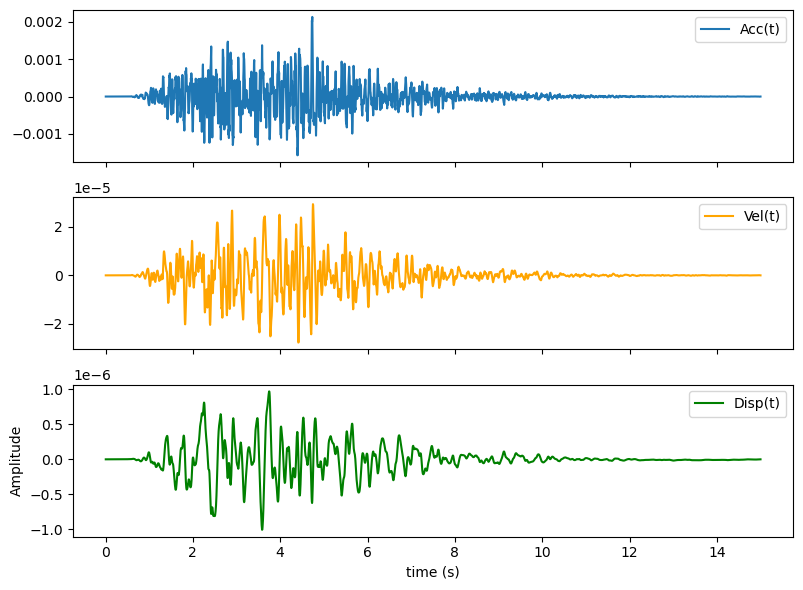

In [3]:
import matlab.engine

# Start the matlab engine
eng = matlab.engine.start_matlab()
# Link to the dir of matlab function
path = r'C:\Users\v196m\Desktop\master_project\Masterarbeit\GroundMotion\GroundMotionGeneration'
eng.cd(path, nargout=0)

# Parameter of GM setting
Start_Time = 0.005
End_time = 15.005
Time_interval = 0.005
Time =  np.arange(Start_Time, End_time, Time_interval)

Time_info = np.array([0.5,	4.51602635361311,	6.51382766164269,	10.8203132545630])
FRF_info  = np.array([85.634147247517, 0.364521248606246, 0.213591303771144])
AriasIntensity = 0.0000508679639647511

# Generate ground motion
time,acc,vel,disp = eng.fns_generateGM_Params(5,Time,100,"Hu_S0", FRF_info, Time_info, AriasIntensity, nargout=4)
acc_signal = np.column_stack((time, acc))
vel_signal = np.column_stack((time, vel))
disp_signal = np.column_stack((time, disp))

time_interval_transient = 0.005
n_time=int(((End_time-Start_Time)/time_interval_transient)+1)

eng.quit()

# Create a figure and three subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8, 6))

# Plot on the first subplot
ax1.plot(np.array(time), np.array(acc), label='Acc(t)')
#ax1.set_ylabel('Amplitude')
ax1.legend()

# Plot on the second subplot
ax2.plot(np.array(time), np.array(vel), label='Vel(t)', color='orange')
#ax2.set_ylabel('Amplitude')
ax2.legend()

# Plot on the third subplot
ax3.plot(np.array(time), np.array(disp), label='Disp(t)', color='green')
ax3.set_xlabel('time (s)')
ax3.set_ylabel('Amplitude')
ax3.legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

2. Performing Transient Analysis 

- Start the pyMAPDL engine

In [54]:
from ansys.mapdl.core import launch_mapdl
mapdl = launch_mapdl(nproc=4)

- Create SDOF system and input the AGM as displacement excitation

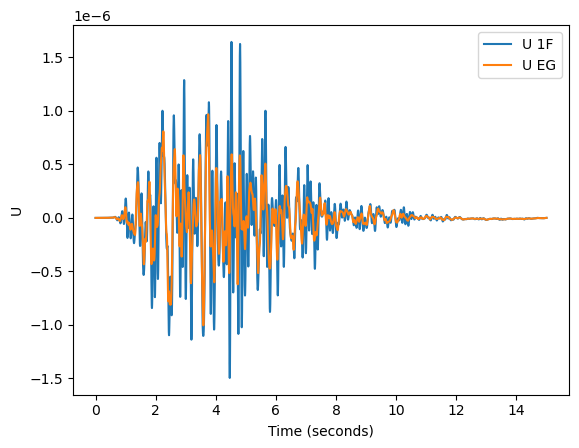

In [55]:
## PREP7
mapdl.prep7()
mapdl.units("SI")  # SI - International system (m, kg, s, K).
# Create Node
mapdl.n(1,"0","0","0")
mapdl.n(2,"0","0","10")

# Define mass21 element 
mapdl.et(1, "MASS21", kop3=2)
mapdl.type(1)
mapdl.real(1)
mapdl.r(1,100)
mapdl.e(2)

mapdl.et(2, "COMBIN14", kop2=3)
mapdl.type(2)
mapdl.real(2)
k = (4*np.pi**2)*10000
mapdl.r(2,k,1000)
mapdl.e(1,2)

mapdl.nsel("ALL")
mapdl.allsel()
mapdl.nummrg("ALL")

mapdl.load_table("ACC_input", acc_signal ,"TIME")
mapdl.load_table("VEL_input", vel_signal ,"TIME")
mapdl.load_table("DISP_input", disp_signal ,"TIME")


## SOLU
mapdl.run("/SOLU")
mapdl.antype(4)  # transient analysis
mapdl.trnopt("FULL")  # full transient analysis

mapdl.outres("ALL","NONE")	
mapdl.outres("NSOL","1")
mapdl.outres("V","1")
mapdl.outres("A","1")

# Time stepping
end_time = End_time
mapdl.time(end_time)  # end time for load step
mapdl.autots("ON")  # use automatic time stepping

# setup where the subset time is 10 seconds, time
mapdl.deltim(0.001, 0.0005, 0.0015)  # substep size (seconds)
#                          -- minimum value shorter than smallest
#                            time change in the table arrays below
mapdl.eqslv("SPARSE")  # use sparse solver
#mapdl.dmprat("0.05")
#mapdl.d("1","ACCZ","%ACC_input%")
mapdl.d("1","UZ","%DISP_input%")
mapdl.solve()

## POST26
mapdl.post26()
U_EG_TS = mapdl.nsol("2","1","U","Z")
U_1F_TS = mapdl.nsol("3","2","U","Z")
time_values = mapdl.post_processing.time_values

plt.plot(time_values,U_1F_TS, label="U 1F")
plt.plot(time_values,U_EG_TS, label="U EG")
#plt.plot(time_values, label="ACC time")
plt.legend()
plt.xlabel("Time (seconds)")
plt.ylabel("U")
plt.show()



3. Perfroming Harmoic analysis to generate FRF then multiple with AGM in freq domain

In [65]:
## PREP7
mapdl.prep7()
mapdl.units("SI")  # SI - International system (m, kg, s, K).

# Create Node
mapdl.n(1,"0","0","0")
mapdl.n(2,"0","0","10")

# Define mass21 element 
mapdl.et(1, "MASS21", kop3=2)
mapdl.type(1)
mapdl.real(1)
mapdl.r(1,100)
mapdl.e(2)

mapdl.et(2, "COMBIN14", kop2=3)
mapdl.type(2)
mapdl.real(2)
k = (4*np.pi**2)*10000
mapdl.r(2,k,1000)
mapdl.e(1,2)

mapdl.nsel("ALL")
mapdl.allsel()
mapdl.nummrg("ALL")

freq = np.array([0,100])
U_input = np.array([1,1])
U_signal = np.column_stack((freq, U_input))
mapdl.load_table("TF_input", U_signal ,"FREQ")

##SOLU
mapdl.run("/SOLU")
mapdl.antype(3)  
mapdl.outres("ALL","NONE")	
mapdl.outres("NSOL","1")

mapdl.harfrq("0.1","100")

#substep = int(100/0.1)
#min_sub = int(100/0.05)
#max_sub = int(100/0.2)
substep = int(100/0.2)
min_sub = int(100/0.1)
max_sub = int(100/0.5)
mapdl.nsubst(substep,min_sub,max_sub)

#mapdl.eqslv("SPARSE")  # use sparse solver
#mapdl.dmprat("0.05")
#mapdl.d("1","ACCZ","%ACC_input%")
mapdl.d("1","UZ","%TF_input%")

mapdl.solve()


## POST26
mapdl.post26()
mapdl.nsol("2","1","U","Z")
mapdl.nsol("3","2","U","Z")

freq_values = mapdl.post_processing.frequency_values
freq_values = np.unique(freq_values)

U_EG_HR = np.empty((0, 3))
U_1F_HR = np.empty((0, 3))

index = 0
for f in freq_values:
    U_EG_real = mapdl.get("U_EG","VARI","2","REAL",f)
    U_EG_imag = mapdl.get("U_EG","VARI","2","IMAG",f)
    U_1F_real = mapdl.get("U_1F","VARI","3","REAL",f)
    U_1F_imag = mapdl.get("U_1F","VARI","3","IMAG",f)

    U_EG_HR = np.vstack((U_EG_HR, np.array([f, U_EG_real , U_EG_imag])))
    U_1F_HR = np.vstack((U_1F_HR, np.array([f, U_1F_real , U_1F_imag])))
    index = index +1

- PostProcessing
  - multiple FRF with Artificial Ground Motion in freq domain
  - IFFT back to time domain

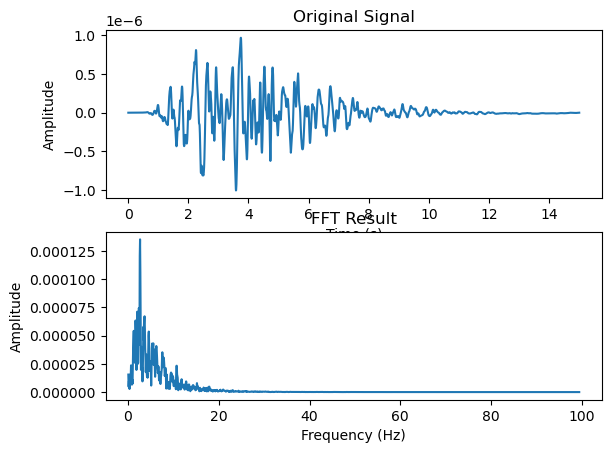

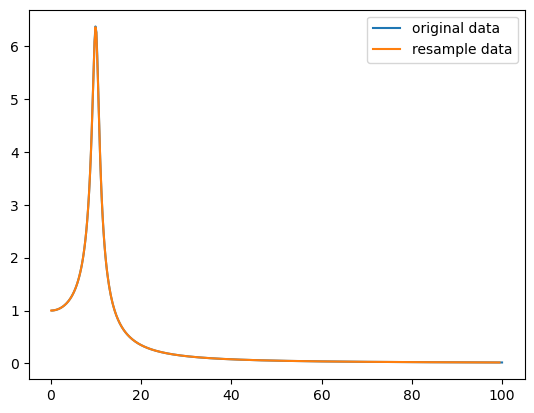

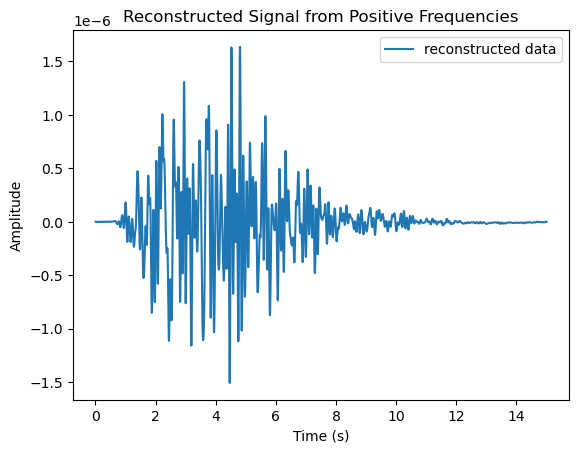

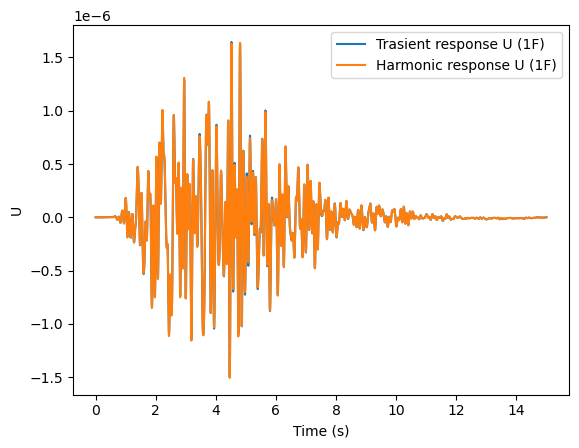

In [68]:
import HalfPositive_FFT_IFFT as HPFFT

# time and signal from AGT
time = np.array(time)
ampl = np.array(disp)
freq,cmplx_values = HPFFT.FFT_half_positive(time,np.squeeze(disp),False,False)

FRF_freq = U_1F_HR[:,0]
FRF_real = U_1F_HR[:,1]
FRF_imag = U_1F_HR[:,2]
FRF_response = FRF_real + 1j * FRF_imag

FRF_freq_resample, FRF_values_resample = HPFFT.signal_resample_inter1(FRF_freq,FRF_response, resamples_type = 'array', resample_list = freq, resample_check = False)
Response = FRF_values_resample*cmplx_values
time_res, ampl_res = HPFFT.IFFT_half_positive(Response, time = time, plot_ = False)

plt.plot(time_values,U_1F_TS, label="Trasient response U (1F)")
plt.plot(time_res,ampl_res,'--', label="Harmonic response U (1F)")
#plt.plot(time,ampl, label="GM")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("U")
plt.show()


In [67]:
mapdl.exit()

Generate Ground Motion, Duration: 5.519026517868042 seconds


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Finish ANSYS simulation, Duration: 63.119412422180176 seconds
Total Duration: 68.63843894004822 seconds


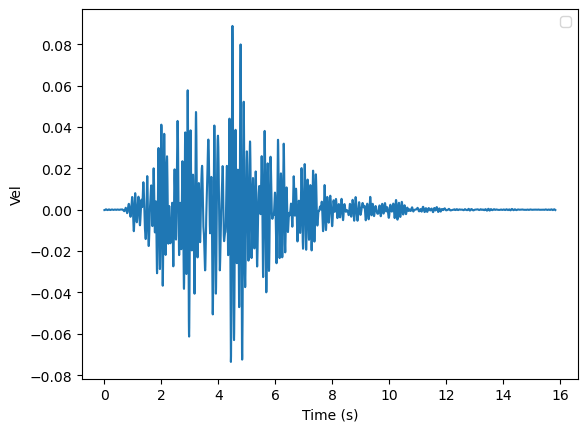

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import GenerateMaxVel as GMV
path = r'C:\Users\v196m\Desktop\master_project\Masterarbeit\GroundMotion\GroundMotionGeneration'
Time_info = np.array([0.5,	4.51602635361311,	6.51382766164269,	10.8203132545630])
FRF_info  = np.array([85.634147247517, 0.364521248606246, 0.213591303771144])
AriasIntensity = 0.0000508679639647511
k = (4*np.pi**2)*10000
str_params = [k,100]
time_generate, Disp_generate = GMV.GenerateMaxVelocity(path,FRF_info,Time_info,AriasIntensity, str_params,5)


plt.plot(time_generate, Disp_generate)
#plt.plot(time,ampl, label="GM")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Vel")
plt.show()